In [3]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import math
from statistics import stdev
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import statistics
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams['figure.figsize'] = 10, 8

In [4]:
#preprocessing
#cols = ['treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr','re74','re75','re78']
cols2 = ['age', 'educ', 'black', 'hisp', 'married', 'nodegr','re74','re75','re78']
#control_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_control.txt', sep='\s+', header = None, names = cols)
#treated_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_treated.txt', sep='\s+', header = None, names = cols)
#lalonde_df = pd.concat([control_df, treated_df], ignore_index=True)
lalonde_df=pd.read_csv('/content/drive/MyDrive/lalonde/lalonde.csv')


lalonde_df['re78'] = np.array(lalonde_df['re78']>0,dtype=float)
x_data=lalonde_df.iloc[:, 1:10]
y_data=lalonde_df.iloc[:, 0]
min_max_scaler = preprocessing.MinMaxScaler()
x_data = pd.DataFrame(min_max_scaler.fit_transform(x_data),columns=cols2)
x_data=x_data.round(decimals=2)

In [5]:
#function to calculate CV
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100

In [6]:
data_probs=pd.DataFrame()
weights=np.zeros(67)
invweights=np.zeros(67)

In [7]:
def models_jobs(model_type):
  cv_weight=[]
  cv_ipw=[]
  weights=np.zeros(93)
  invweights=np.zeros(93)
  tps_mean=[]
  tps_std=[]
  cv_of_weight=0
  cv_of_ipw=0
  for i in range(1,200):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=i)
    #X_train_t=x_train.iloc[:, 2:30]
    X_train_t=x_train.iloc[:, 0:8]
    Y_train_t=y_train
    X_test_t=x_test.iloc[:, 0:8]
    Y_test_t=y_test
    tps_arr=np.zeros(67)
    if(model_type==0):

      model=SVC(probability=True,kernel='linear',C=100)
    elif(model_type==1):

      model = LogisticRegression()

    else:
      model = lgb.LGBMClassifier(max_depth=10)

    model.fit(X_train_t, Y_train_t)
    expected_y  = Y_test_t
    expected_yt  = Y_train_t
    predicted_y =model.predict(X_test_t)
    predicted_yt=model.predict(X_train_t)
    probs=model.predict_proba(X_test_t)
    data_probs['treat'] = y_test.values



    data_probs.loc[:,['P0','P1']] = probs
    data_probs['ipw']= np.where (data_probs['treat']==1, 1/data_probs['P1'], 1/data_probs['P0'])
    data_probs['e']= np.where (data_probs['treat']==1, 1-data_probs['P1'], 1-data_probs['P0'])
    tps_arr= np.array(np.where (data_probs['treat']==1, data_probs['P1'], data_probs['P0']))
    tps_mean.append(statistics.mean(tps_arr))
    tps_std.append(statistics.variance(tps_arr))
    #data_probs.loc[:, 'ep'] = np.power(data_probs.loc[:, 'e'],p)
    data_probs.loc[:, 'ep'] =(data_probs.loc[:, 'e'])

    weightsn = np.array(data_probs['ep'])
    invweightsn = np.array(data_probs['ipw'])

    weights =np.array(weights) + np.array(data_probs['ep'])
    invweights =np.array(invweights) + np.array(data_probs['ipw'])


    cv_of_weight=cv_of_weight+cv(weightsn)
    cv_of_ipw=cv_of_ipw+cv(invweightsn)
    cv_weight.append(cv_of_weight/i)
    cv_ipw.append(cv_of_ipw/i)

  data_probs['ep']=(weights/200)
  data_probs['ipw']=(invweights/200)
  weights=(weights/200)
  invweights=(invweights/200)
  treat_weights=np.array(data_probs.loc[data_probs['treat']==1,'ep'])
  control_weights=np.array(data_probs.loc[data_probs['treat']==0,'ep'])

  treat_ipw=np.array(data_probs.loc[data_probs['treat']==1,'ipw'])
  control_ipw=np.array(data_probs.loc[data_probs['treat']==0,'ipw'])

  return cv_weight,cv_ipw,model

In [8]:
#0 =underfit, 1=moderate, 2=overfit
model_type=1
cv_weight,cv_ipw,model=models_jobs(model_type)
if(model_type==0):
  typeis='underfit'
elif(model_type==1):
  typeis='good'
else:
  typeis='overfit'



103.35680740896142


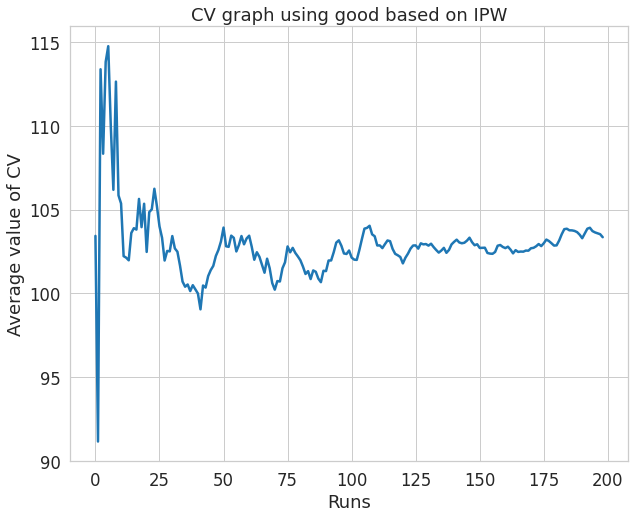

In [9]:
plt.plot((cv_ipw))  # density=False would make counts
plt.xlabel('Runs')
plt.title('CV graph using '+ typeis +' based on IPW')
plt.ylabel('Average value of CV')
print (cv_ipw.pop())


91.86816409341428


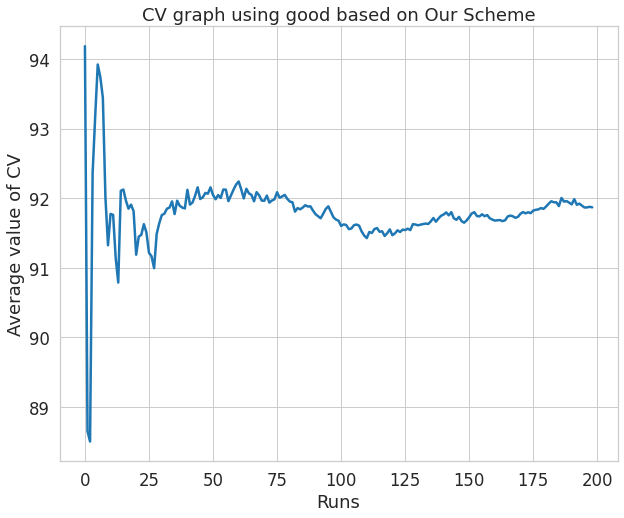

In [10]:
plt.plot((cv_weight))  # density=False would make counts
plt.xlabel('Runs')
plt.title('CV graph using '+ typeis +' based on Our Scheme')
plt.ylabel('Average value of CV')
print (cv_weight.pop())

In [11]:

def cal_SMD_Unweighted(x,dunw):
  for i in range(200):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=i)
    x_test['treat'] = y_test.values
    data_treat=x_test[x_test['treat']==1]
    data_control=x_test[x_test['treat']==0]
    data_treat[x].mean()
    data_control[x].mean()
    A=(data_treat[x].mean()-data_control[x].mean())
    B=math.sqrt((np.var(data_treat[x])+np.var(data_control[x]))/2)
    dunw=dunw+(100*(A/B))
  return (dunw/200)

def cal_SMD_weighted(x,dw):
  for i in range(200):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=i)
    X_train_d=x_train.iloc[:, 0:8]
    Y_train_d=y_train
    X_test_d=x_test.iloc[:, 0:8]
    Y_test_d=y_test
    if(model_type==0):

        modeld=SVC(probability=True,kernel='linear',C=100)
    elif(model_type==1):
        modeld = LogisticRegression()
    else:
        modeld = lgb.LGBMClassifier(max_depth=10)

    #modeld = LogisticRegression(max_iter=2)
    #modeld = LogisticRegression(solver='liblinear')
    #modeld = lgb.LGBMClassifier(max_depth=2,num_leaves=10)
    #model.fit(X_train_t, Y_train_t)
    #cls = CalibratedClassifierCV(model)
    modeld.fit( X_train_d, Y_train_d )
    #arr1=model.predict_proba(X_train)
    probsd=modeld.predict_proba(X_test_d)
    p=1
    data_probsd = pd.concat([X_test_d, Y_test_d], axis = 1)
    data_probsd.loc[:,['P0','P1']] = probsd
    data_probsd['ipw']= np.where (data_probsd['treat']==1, 1/data_probsd['P1'], 1/data_probsd['P0'])
    #data_probsd['ipw']= 1/data_probsd['P1']
    data_probsd.loc[:, 'e'] = np.abs(data_probsd['treat'] - data_probsd['P1'])
    data_probsd.loc[:, 'ep'] =(data_probsd.loc[:, 'e']*p)
    data_treat=data_probsd[data_probsd['treat']==1]
    data_control=data_probsd[data_probsd['treat']==0]
    treat_mean=sum(data_treat[x]*data_treat['ep'])/sum(data_treat['ep'])
    control_mean=sum(data_control[x]*data_control['ep'])/sum(data_control['ep'])
    A=(treat_mean-control_mean)
    var_treat=(sum(data_treat['ep'])/((sum(data_treat['ep'])**2)-(sum(data_treat['ep']**2))))*sum((data_treat[x]-treat_mean)**2 *(data_treat['ep']))
    var_control=(sum(data_control['ep'])/((sum(data_control['ep'])**2)-(sum(data_control['ep']**2))))*sum((data_control[x]-control_mean)**2 *(data_control['ep']))
    B=math.sqrt((var_treat+var_control)/2)
    dw=dw+(100*(A/B))
  return (dw/200)

def cal_SMD_weightedinv(x,dipw):
  for i in range(200):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=i)
    X_train_d=x_train.iloc[:, 0:8]
    Y_train_d=y_train
    X_test_d=x_test.iloc[:, 0:8]
    Y_test_d=y_test
    if(model_type==0):

      modeld=SVC(probability=True,kernel='linear',C=100)
    elif(model_type==1):
      modeld = LogisticRegression()
    else:
      modeld = lgb.LGBMClassifier(max_depth=10)

    modeld.fit( X_train_d, Y_train_d )
    #arr1=model.predict_proba(X_train)
    probsd=modeld.predict_proba(X_test_d)
    p=1
    data_probsd = pd.concat([X_test_d, Y_test_d], axis = 1)
    data_probsd.loc[:,['P0','P1']] = probsd
    data_probsd['ipw']= np.where (data_probsd['treat']==1, 1/data_probsd['P1'], 1/data_probsd['P0'])
    #data_probsd['ipw']= 1/data_probsd['P1']
    data_probsd.loc[:, 'e'] = np.abs(data_probsd['treat'] - data_probsd['P1'])
    data_probsd.loc[:, 'ep'] =(data_probsd.loc[:, 'e'])
    data_treat=data_probsd[data_probsd['treat']==1]
    data_control=data_probsd[data_probsd['treat']==0]
    treat_mean=sum(data_treat[x]*data_treat['ipw'])/sum(data_treat['ipw'])
    control_mean=sum(data_control[x]*data_control['ipw'])/sum(data_control['ipw'])
    A=(treat_mean-control_mean)
    var_treat=(sum(data_treat['ipw'])/((sum(data_treat['ipw'])**2)-(sum(data_treat['ipw']**2))))*sum((data_treat[x]-treat_mean)**2 *(data_treat['ipw']))
    var_control=(sum(data_control['ipw'])/((sum(data_control['ipw'])**2)-(sum(data_control['ipw']**2))))*sum((data_control[x]-control_mean)**2 *(data_control['ipw']))
    B=math.sqrt((var_treat+var_control)/2)
    dipw=dipw+(100*(A/B))
  return (dipw/200)


In [12]:
dunw=0
dipw=0
dw=0
SMD_weighted=[]
SMD_unweighted=[]
SMD_weightedinv=[]
feat=['age','educ','re74','re75']
for i in feat:
    SMD_weighted.append(np.abs(cal_SMD_weighted(i,dw)))
    SMD_unweighted.append(np.abs(cal_SMD_Unweighted(i,dunw)))
    SMD_weightedinv.append(np.abs(cal_SMD_weightedinv(i,dipw)))

Text(0.5, 1.0, 'Standardized difference with our scheme good model')

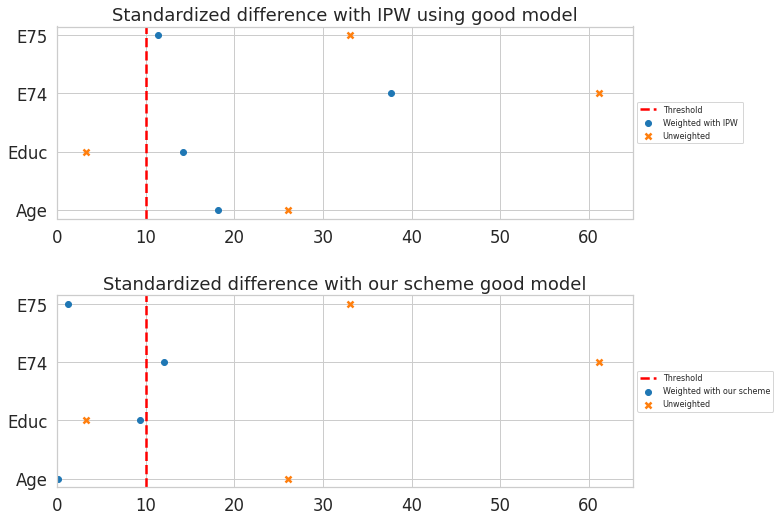

In [13]:
variables = ["Age", "Educ", "E74", "E75"]
fig, axs = plt.subplots(2)
#fig.suptitle('Absolute Standardized Difference on IHDP')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)



axs[0].scatter(SMD_weightedinv,variables, label='Weighted with IPW ', marker='o')
axs[0].scatter(SMD_unweighted,variables, label='Unweighted', marker='x')
axs[0].axvline(10, linestyle='dashed',color='r', label='Threshold')
axs[0].legend(prop={'size': 8},loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].set_xlim([0,65])
#axs[0].set_title('Standardized difference with IPW using '+typeis +' model')
axs[0].set_title('Standardized difference with IPW using '+ typeis +' model')

axs[1].scatter(SMD_weighted,variables, label='Weighted with our scheme', marker='o')
axs[1].scatter(SMD_unweighted,variables, label='Unweighted', marker='x')
axs[1].axvline(10, linestyle='dashed',color='r', label='Threshold')
axs[1].legend(prop={'size': 8},loc='center left', bbox_to_anchor=(1, 0.5))
axs[1].set_xlim([0,65])
#axs[1].set_title('Standardized difference with our scheme '+typeis +' model')
axs[1].set_title('Standardized difference with our scheme '+ typeis +' model')

In [14]:
#function to calculate propensity scores
data_probs=pd.DataFrame()
data_probs5=pd.DataFrame()
data_probs6=pd.DataFrame()
data_probs7=pd.DataFrame()

mean_weight_0=[]
std_weight_0=[]
mean_weight_1=[]
std_weight_1=[]

mean_ipw_0=[]
std_ipw_0=[]
mean_ipw_1=[]
std_ipw_1=[]

mean_unw_0=[]
std_unw_0=[]
mean_unw_1=[]
std_unw_1=[]
def prop_cal():
  for i in range(1,200):
      x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.30, random_state=i)
      x_trainv, x_testv, y_trainv, y_testv = train_test_split(x_data, y_data, test_size=0.30, random_state=i)
      #X_train_t=x_train.iloc[:, 2:30]
      X_train_t=x_train.iloc[:, 0:8]
      Y_train_t=y_train
      X_test_t=x_test.iloc[:, 0:8]
      Y_test_t=y_test

      #model = LogisticRegression()

      model.fit(X_train_t, Y_train_t)
      expected_y  = Y_test_t
      expected_yt  = Y_train_t
      predicted_y =model.predict(X_test_t)
      predicted_yt=model.predict(X_train_t)
      probs=model.predict_proba(X_test_t)
      data_probs['treat'] = y_test.values
      data_probs.loc[:,['P0','P1']] = probs
      data_probs['ipw']= np.where (data_probs['treat']==1, 1/data_probs['P1'], 1/data_probs['P0'])
      data_probs['e']= np.where (data_probs['treat']==1, 1-data_probs['P1'], 1-data_probs['P0'])
      #data_probs.loc[:, 'ep'] = np.power(data_probs.loc[:, 'e'],p)
      data_probs.loc[:, 'ep'] =(data_probs.loc[:, 'e'])

      weightsp =np.array(data_probs['ep'])
      invweightsp =np.array(data_probs['ipw'])

      model5 = LogisticRegression()
      model5.fit( X_test_t, Y_test_t,sample_weight=weightsp)
      x_testvt=x_testv.iloc[:, 0:8]
      probs5=model5.predict_proba(x_testvt)
      data_probs5['treat'] = y_testv.values
      data_probs5.loc[:,['P0','P1']] = probs5
      mean_weight_0.append(statistics.mean(np.array(data_probs5['P0'])))
      std_weight_0.append(statistics.stdev(np.array(data_probs5['P0'])))
      mean_weight_1.append(statistics.mean(np.array(data_probs5['P1'])))
      std_weight_1.append(statistics.stdev(np.array(data_probs5['P1'])))

      #-----------------------------------------
      model6 = LogisticRegression()
      model6.fit( X_test_t, Y_test_t,sample_weight=invweightsp)
      x_testvt=x_testv.iloc[:, 0:8]
      probs6=model6.predict_proba(x_testvt)
      #probs6=model6.predict_proba(X_test_t)
      data_probs6['treat'] =  y_testv.values
      data_probs6.loc[:,['P0','P1']] = probs6
      mean_ipw_0.append(statistics.mean(np.array(data_probs6['P0'])))
      std_ipw_0.append(statistics.stdev(np.array(data_probs6['P0'])))
      mean_ipw_1.append(statistics.mean(np.array(data_probs6['P1'])))
      std_ipw_1.append(statistics.stdev(np.array(data_probs6['P1'])))
    #-----------------------------------------------------------------
      model7 = LogisticRegression()
      model7.fit( X_test_t, Y_test_t)
      x_testvt=x_testv.iloc[:, 0:8]
      probs7=model7.predict_proba(x_testvt)
      data_probs7['treat'] = y_testv.values
      data_probs7.loc[:,['P0','P1']] = probs7
      mean_unw_0.append(statistics.mean(np.array(data_probs7['P0'])))
      std_unw_0.append(statistics.stdev(np.array(data_probs7['P0'])))
      mean_unw_1.append(statistics.mean(np.array(data_probs7['P1'])))
      std_unw_1.append(statistics.stdev(np.array(data_probs7['P1'])))

In [15]:
prop_cal()
#normal distribution of avg mean and standard deviation
rng = np.random.default_rng(seed=42)
w0 = rng.normal(statistics.mean(mean_weight_0), statistics.mean(std_weight_0), 100)
w1 = rng.normal(statistics.mean(mean_weight_1), statistics.mean(std_weight_1), 100)
ipw0 = rng.normal(statistics.mean(mean_ipw_0), statistics.mean(std_ipw_0), 100)
ipw1 = rng.normal(statistics.mean(mean_ipw_1), statistics.mean(std_ipw_1), 100)
unw0 = rng.normal(statistics.mean(mean_unw_0), statistics.mean(std_unw_0), 100)
unw1 = rng.normal(statistics.mean(mean_unw_1), statistics.mean(std_unw_1), 100)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Count')

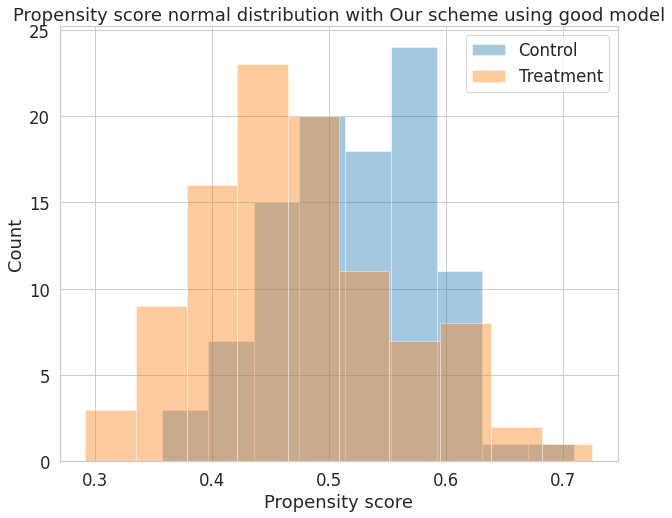

In [16]:
#Normal distribution of Our scheme
ax1 = sns.distplot(w0, label="Control",kde=False)
ax1=sns.distplot(w1, label="Treatment",kde=False)
ax1.set_xlabel('Propensity score')
plt.legend()
plt.title('Propensity score normal distribution with Our scheme using '+ typeis +' model')
plt.legend()
ax1.set_ylabel('Count')

Text(0, 0.5, 'Count')

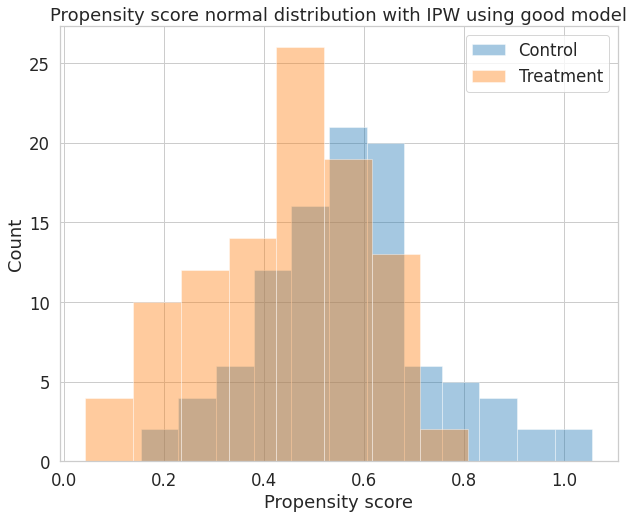

In [17]:
#Normal distribution of IPW
ax2 = sns.distplot((ipw0), label="Control",kde=False)
ax2=sns.distplot((ipw1), label="Treatment",kde=False)
ax2.set_xlabel('Propensity score')
plt.legend()

plt.title('Propensity score normal distribution with IPW using '+ typeis +' model')
plt.legend()
ax2.set_ylabel('Count')

Text(25.200000000000003, 0.5, 'Count')

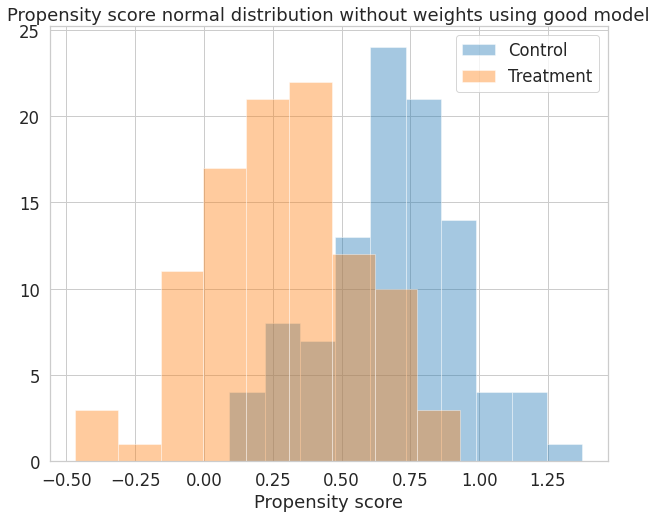

In [18]:
#Normal distribution of Unweighted
ax3 = sns.distplot((unw0), label="Control",kde=False)
ax3=sns.distplot((unw1), label="Treatment",kde=False)
ax3.set_xlabel('Propensity score')
plt.legend()
plt.title('Propensity score normal distribution without weights using '+ typeis +' model')
plt.legend()
ax2.set_ylabel('Count')